# **Transições de fase do modelo de Ising de campo transversal com NetKet**



*   PET - Física UFRN
*   Petiano: Tiago Pernambuco Toledo de Macêdo
*   Data: 17 de Novembro de 2023

O problema quântico de muitos corpos (muitas vezes abreviado como QMBP, do inglês quantum many body problem) é uma classe de problemas em física conhecida por ser difícil de trabalhar devido ao alto custo computacional envolvido na simulação das muitas partículas. O objetivo desse notebook é introduzir uma metodologia recente chamada Neural-Network Quantum States (NQS) [1] e a biblioteca NetKet [2], criada para trabalhar QMBP utilizando essa metodologia e usá-las para encontrar transições de fase em um modelo de Ising de campo transversal (também chamado de modelo de Ising quântico), [o análogo "clássico" do qual foi trabalhado em um notebook anterior](https://github.com/andersonmsn0/PET.py/blob/main/Simulando%20ferromagneto%20modelo%20ising%202d/Simulando%20ferromagneto%20modelo%20ising%202d.ipynb).


## **O modelo de Ising**
O modelo de Ising é típicamente considerado o modelo mais simples para um sistema de spins interagentes. No modelo de Ising clássico, o Hamiltoniano do sistema, que representa sua energia total, é dado por:

$$ H = -\sum_{i,j} J_{ij} \sigma_i \sigma_j -  \mu \sum_{j} h_j \sigma_j,$$

em que o somatório do primeiro termo é dado ao longo de todos os pares de primeiros vizinhos, onde $J_{ij}$ representa a intensidade da interação entre eles, $\mu$ o momento magnético, e para o segundo termo, temos uma soma em cada spin no sistema da intensidade do campo magnético longitudinal em $j$, $h_j$, e o spin em $j$, $\sigma_j$.

Esse modelo é chamado "clássico" pois, embora o spin seja uma quantidade inerentemente quântica, o fato de que só consideramos spins e campo magnético na mesma direção (tipicamente atribui-se o eixo $z$ a essa direção), o que faz com que o sistema possa ser trabalhando usando métodos típicos da física estatística clássica.

Nesse notebook, substituiremos o termo ligado ao campo longitudinal por um campo transversal no eixo $x$ e consideraremos que a interação entre os spins vizinhos é a mesma para cada par de spins. Assim, nosso Hamiltoniano toma a forma

$$H = -J\sum_{i,j} \sigma_{i}^z \sigma_{j}^z - h\sum_{j} \sigma_{j}^x .$$

O comportamento interessante do sistema físico governado por esse Hamiltoniano vem do fato de que, na mecânica quântica, os spins nas direções $x$ e $z$ não comutam. Isto é, não podem ter valores bem definidos no mesmo instante. Esse fato gera dinâmicas diferentes do caso clássico, permitindo magnetização em ambos os eixos $x$ e $z$ e apresentando transições de fase que serão exploradas mais à frente.

## **Variational Monte-Carlo e Neural-Network Quantum States**

Como citado na introdução ao notebook, simular um sistema quântico de muitos corpos é um trabalho extremamente custoso, computacionalmente falando, uma vez que sistemas quânticos tem tipos de correlações entre partículas inerentes a eles que não são apresentados por sistemas clássicos.

Num sistema clássico de muitos corpos, são necessários $k\cdot n$ números para representar um sistema de n partículas em que cada parícula possui $k$ graus de liberdade (pode ter seu estado descrito por $k$ números). No caso quântico, porém, o fato de que o sistema se encontra, no geral, numa superposição de combinações de estados de cada partículas, são necessários $k^n$ números para descrever $n$ partículas de $k$ graus de liberdade cada. Nos termos da ciência da computação, um problema de complexidade exponencial é chamado ineficiente, o que é uma boa descrição para essa situação, uma vez que, conforme o espaço de Hilbert de um sistema de muitos corpos cresce muito rápido, cresce a nossa dificuldade de trabalhar esses sistemas de forma exata, precisando realizar algum tipo de aproximação.

Um dos métodos mais utilizados para tratar sistemas grandes de muitos corpos é o chamado Variational Monte Carlo (VMC), que consiste em calcular o valor esperado da energia do sistema como sendo a média de energias locais:

$$E(a) = \frac{\Psi^*(a)H\Psi(a)}{\Psi^*(a)\Psi(a)} = avg[E_{loc}(X)],$$
onde $E_{loc}(X) = \frac{H\Psi(X, a)}{\Psi(X, a)}$ são energias locais e $a$ é um conjunto de parâmetros variacionais. Podemos então usar uma distribuição de probabilidade $P(X, a) = \frac{|{\Psi(X, a)}|^2}{\int |{\Psi(X, a)}|^2 dX}$ para amostrar estados que podem ser otimizados para obter uma boa aproximação do ground state (estado fundamental) do sistema e da sua energia.

O método de Neural-Network Quantum States (NQS) consiste em parametrizar um estado quântico variacional (VQS) em termos de uma rede neural e otimizar o estado ao treinar essa rede neural, assim otimizando seus parâmetros a partir de um otimizador (que pode ser qualquer otimizador já existente na literatura científica de inteligência artifical). A figura abaixo ilustra como isso é feito para um sistema de N spins através de uma Restricted Boltzmann Machine.

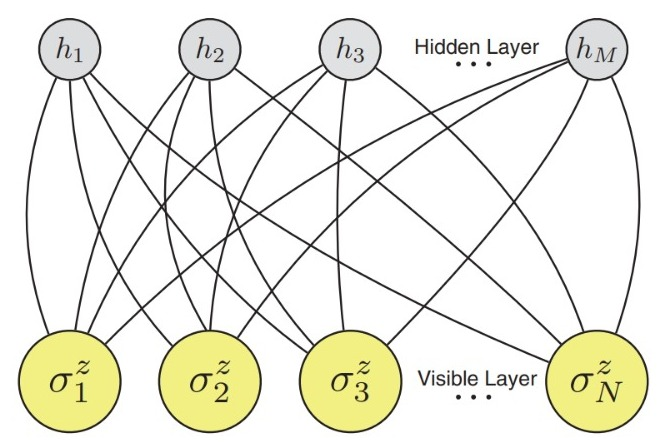

Fonte: [1]

Na figura, uma camada visível de neurônios representa o valor de cada spin na rede enquanto uma camada escondida tem neurônios que se ligam com a camada visível inteira para computar as correlações entre as partículas do sistema. Esse método basicamente trata a função de onda de um sistema de muitos corpos como uma "caixa preta" computacional que recebe uma configuração do sistema e retorna sua amplitude de acordo com a função de onda parametrizada. Uma das maiores vantagens do NQS, que será trabalhada nesse notebook, é a facilidade que se tem para implementar condições de simetria na otimização da energia do sistema, reduzindo bastante a quantidade de parâmetros que devem ser otimizados. O quanto esses parâmetros são reduzidos depende da geometria do sistema.

## **Introdução ao NetKet**



Agora que terminamos a introdução teórica, podemos importar as bibliotecas que vamos utilizar ao longo do notebook e começar a nos familiarizar com as ferramentas do NetKet.

Primeiramente, é necessário instalar o NetKet. Para isso, usaremos o comando

```
pip install --upgrade "netket[cuda]"
```

O termo `--upgrade` garante que todas as bibliotecas necessárias para operar o NetKet sejam instaladas junto com ele e o `[cuda]` é necessário para poder utilizar processamento em GPU com o NetKet, o que é simples de se implementar, uma vez que o NetKet é construído com base na biblioteca Jax, muito usada para computação em GPU.

É importante salientar que o NetKet só pode ser usado com GPU no Linux devido aos pré-requisitos de outras bibliotecas que o NetKet usa. Por isso, não utilizaremos essa função dele nesse notebook.

In [1]:
pip install --upgrade "netket[cuda]"

^C
Note: you may need to restart the kernel to use updated packages.


INFO: pip is looking at multiple versions of cffi to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of cffi to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of numba4jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. If you want to abort this run, you can press Ctrl + C to do so. To improve how pip performs, tell us what happened here: https://pip.pypa.io/surveys/backtracking
INFO: pip is looking at multiple versions of llvmlite to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of numba4jax to determine which version is compatible with other requirements. This coul

    ERROR: Command errored out with exit status 1:
     command: 'c:\Users\moise\anaconda3\python.exe' -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\moise\\AppData\\Local\\Temp\\pip-install-r9al4dy5\\cffi_a177d9b3774a436c926bcb4a0ead4af7\\setup.py'"'"'; __file__='"'"'C:\\Users\\moise\\AppData\\Local\\Temp\\pip-install-r9al4dy5\\cffi_a177d9b3774a436c926bcb4a0ead4af7\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\moise\AppData\Local\Temp\pip-pip-egg-info-7uc94bnw'
         cwd: C:\Users\moise\AppData\Local\Temp\pip-install-r9al4dy5\cffi_a177d9b3774a436c926bcb4a0ead4af7\
    Complete output (19 lines):
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "C:\Users\moi

Agora, para importar as bibliotecas que serão usadas ao longo do notebook:

In [ ]:
import netket as nk
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

Podemos também usar a extensão `version_information` para exibir as especificações de versão de cada uma das bibliotecas utilizadas:

In [ ]:
pip install version_information

In [ ]:
%load_ext version_information
%version_information NetKet, Matplotlib, Numpy, Scipy

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.10.12 64bit [GCC 11.4.0]
IPython 7.34.0
OS Linux 5.15.120+ x86_64 with glibc2.35
NetKet (numba 0.58.1 (/usr/local/lib/python3.10/dist-packages), Requirement.parse('numba<0.58,>=0.52'), {'numba4jax'})
Matplotlib 3.7.1
Numpy 1.23.5
Scipy 1.11.3
Sat Nov 18 03:02:55 2023 UTC

Agora estamos prontos para começar! A primeira função do NetKet que vamos utilizar aqui é a de gerar grafos. Em primeira vista isso pode não parecer muito útil para tratar sistemas quânticos, mas é uma das coisas que torna o NetKet tão intuitivo de usar. Os grafos podem ser usados para construir o nosso reticulado! Na célula abaixo, a função `Chain` do módulo `graph` do NetKet é usada para gerar uma corrente unidmensional com condições de contorno periódicas (pbc, do inglês periodic boundary conditions) e desenhá-la no plano cartesiano. Note que cada um dos nodos no grafo estão conectados com seus vizinhos com a exceção das extremidades, que também estão ligadas entre si. Isso se deve ao parâmetro `pbc = True` passado à função, que faz com que o sistema se comporte como se fosse uma parte pequena de um sistema que repete esse padrão periodicamente no espaço.

<Axes: >

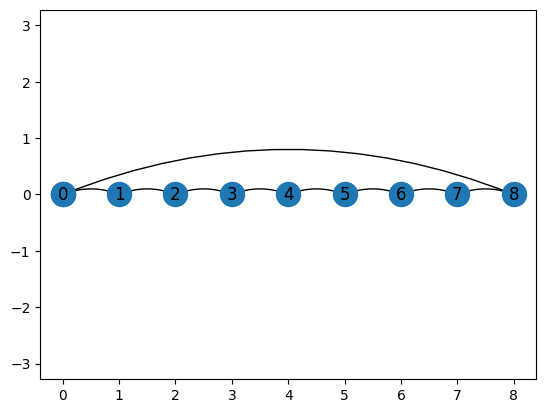

In [ ]:
graph = nk.graph.Chain(9, pbc = True)
graph.draw()

Agora que temos a geometria do nosso sistema, a primeira coisa que precisamos fazer para começar a trabalhar nele é definir o espaço de Hilbert dos seus estados. Para isso, criaremos o espaço de Hilbert de um sistema partículas de spin 1/2 com um número de partículas igual ao número de nodos do nosso grafo. Isso definirá os graus de liberdade do nosso sistema. Para um sistema de spin como o modelo de Ising, o espaço de Hilbert $\mathcal{H}$ tem dimensão $2^N$ para $N$ partículas, o que para os 9 nodos do nosso grafo dá $\dim(\mathcal{H}) = 512$. Isso quer dizer que, para 9 partículas, o Hamiltoniano do nosso sistema será uma matriz com 512 linhas e 512 colunas! Com isso, fica mais fácil visualizar o porquê do problema quântico de muitos corpos ser tão complicado de se trabalhar.

In [ ]:
hi = nk.hilbert.Spin(s = 1/2, N = graph.n_nodes)

Agora que definimos o nosso espaço de Hilbert, precisamos definir mais algumas coisas:


*   O Hamiltoniano do sistema;
*   Um modelo de rede neural para usar de ansatz;
*   Um otimizador para a nossa rede neural;
*   Um sampler para realizar amostragem de estados;
*   Um precondicionador para melhorar o desempenho da otimização (essa etapa é opcional, mas melhora o desempenho do nosso programa).

O NetKet tem todas essas coisas prontas para implementação com funções próprias para isso.

Para o Hamiltoniano, utilizamos o módulo `operator` que tem entre suas funções a função `Ising`, que cria automaticamente o Hamiltoniano do modelo de Ising dado um espaço de Hilbert, um grafo e as intensidades da interação $J$ e do campo magnético transversal $h$.

Para o modelo, utilizaremos uma Restricted Boltzmann Machine (RBM), como a que foi descrita brevemente na seção anterior. Os parâmetros passados a ela abaixo são a densidade de atributos $\alpha$, que representa quantos valores são passados à rede neural por camada e `param_dtype = complex`, que define que a RBM não deve descartar a parte imaginária dos valores passados a ela. Isso é importante uma vez que toda a descrição da mecânica quântica utiliza números complexos, logo, não utilizá-los na descrição do nosso sistema ignoraria propriedades importantes do mesmo.

O otimizador que utilizaremos aqui é o Root Mean Square Propagation. Não entrarei em detalhes sobre o funcionamento desse otimizador, mas ele tem a propriedade de taxa de aprendizado (learning rate) adaptativa, o que faz com que seja bastante versátil para otimização de redes neurais. O learning rate do otimizador pode ser descrito como o "tamanho do passo" que ele dá a cada iteração da otimização. Utilizar um learning rate muito pequeno pode fazer com que o seu otimizador fique preso em mínimos locais ou não convirja para o valor correto rápido o suficiente. Por outro lado, um learning rate grande demais pode fazer com que um passo passe direto pelo valor correto e o ignore. Dessa forma, o learning rate ideal para uma rede neural é altamente dependente do problema, o que torna otimizadores adaptativos mais versáteis que os não-adaptativos, uma vez que eles tem a capacidade de alterar seu learning rate ao longo da otimização.

Para o sampler, ou "amostrador", em uma tradução livre, utilizaremos a função `MetropolisLocal` do módulo `sampler` do NetKet que, no caso de sistemas de spin 1/2 como esse, equivale a "flipar", ou inverter a direção de um spin e calcular a probabilidade de transição para aquele estado, como já foi realizado no outro notebook citado na introdução.

Por fim, o precondicionador utilizado é a reconfiguração estocástica (SR, do inglês stochastic reconfiguration), que utiliza a informação carregada no Quantum Geometric Tensor (QGT), tensor métrico associado à variedade topológica na qual um estado variacional é definido, para "precondicionar" o gradiente de otimização, o que efetivamente "dá uma noção" ao gradiente do estado que estamos procurando. O QGT é uma entidade matemática complexa e discussão de seu funcionamento foge do escopo desse notebook. A implementação `QGTOnTheFly` utilizada no código abaixo permite computar o QGT mais eficientemente ao não computar a matriz que o representa inteira, e passar o termo `holomorphic = True` ao QGT que a função de onda do sistema é holomórifca, permitindo assim que ele seja utilizado em algoritmos mais eficientes que presumem holomorfia e a requerem para funcionar.

In [ ]:
H = nk.operator.Ising(hilbert = hi, h = 1, J = 1, graph = graph)
model = nk.models.RBM(alpha = 1, param_dtype = complex)
op = nk.optimizer.RmsProp(learning_rate = 0.05)
sampler = nk.sampler.MetropolisLocal(hi)
precon = nk.optimizer.SR(qgt = nk.optimizer.qgt.QGTOnTheFly(holomorphic = True))

Agora que definimos todas essas ferramentas, podemos criar um estado variacional para representar um primeiro chute do ground state do sistema para que possamos otimizá-lo. Isso é feito passando o sampler e o modelo definidos acima à função `vqs.MCState`. O número de parâmetros do estado que precisam ser otimizados pode ser visualizado com o método `vstate.n_parameters`.

In [ ]:
vstate = nk.vqs.MCState(sampler = sampler, model = model)
print("Esse estado variacional tem", vstate.n_parameters, "parâmetros.")

Esse estado variacional tem 99 parâmetros


Tendo o nosso estado pronto, o Hamiltoniano que governa o sistema e o nosso otimizador, podemos agora rodar um driver e aproximar o ground state da nossa cadeia de spins!

In [ ]:
driver = nk.driver.VMC(H, optimizer = op, variational_state = vstate, preconditioner = precon, diag_shift = 1e-2)

In [ ]:
driver.run(n_iter = 50, out = 'out')

100%|██████████| 50/50 [00:04<00:00, 11.32it/s, Energy=-11.282+0.008j ± 0.020 [σ²=0.419, R̂=1.0057]]


(JsonLog('out', mode=write, autoflush_cost=0.005)
   Runtime cost:
   	Log:    0.018377304077148438
   	Params: 0.0009434223175048828,)

Com o estado variacional agora otimizado, podemos encontrar o valor esperado da energia do ground state, definida matematicamente como $\Psi^*H\Psi$ para um vetor de estado $\Psi$ e um Hamiltoniano $H$. Isso pode ser feito a partir do método `vstate.expect` passando como parâmetro o Hamiltoniano do modelo de Ising que definimos a pouco.

In [ ]:
print(vstate.expect(H))

-11.304-0.002j ± 0.017 [σ²=0.304, R̂=1.0067]


Agora temos uma aproximação da energia do ground state! É interessante apontar que as estatísticas do NetKet também trazem a informação da margem de erro, variância ($\sigma^2$) e o valor $\hat{R}$, um estimador de convergência de Monte-Carlo, que deve estar próximo de 1 para indicar uma boa convergência. No geral, deve-se atentar ao encontrar $|\hat{R}| > 1.1$, o que geralmente indica uma má compatibilidade ou viés do seu sampler com relação ao sistema simulado.

Um outro ponto importante do netket é que ele não gera operadores na sua forma matricial, mas sim como uma classe de operadores própria da biblioteca. Para recuperar a forma matricial de um operador, podemos utilizar os métodos `to_dense` ou `to_sparse`, que é mais rápido mas depende de um conhecimento prévio sobre se a matriz é composta majoritariamente de 0s.

In [ ]:
Hamil = H.to_dense()

In [ ]:
print(Hamil)

[[ 9 -1 -1 ...  0  0  0]
 [-1  5  0 ...  0  0  0]
 [-1  0  5 ...  0  0  0]
 ...
 [ 0  0  0 ...  5  0 -1]
 [ 0  0  0 ...  0  5 -1]
 [ 0  0  0 ... -1 -1  9]]


In [ ]:
print(Hamil.shape)

(512, 512)


Com isso podemos visualizar bem o nosso Hamiltoniano, mas não só isso! Tendo a matriz pronta, podemos utilizar um eigensolver como o da biblioteca SciPy utilizado a baixo para calcular o valor exato da energia do ground state que aproximamos. Vale lembrar que esse método só é plausível para sistemas pequenos e não funciona na prática em problemas mais realistas.

In [ ]:
print(min(sp.linalg.eigvals(Hamil)))

(-11.342563639235436+0j)


Comparando esses dois valores, não é difícil de ver que o erro está na segunda casa decimal, o que parece bom! Mas deve-se lembrar que esse é um sistema simples e, embora tenhamos conseguido um bom resultado com poucas iterações, esse resultado pode e deve ser melhorado para sistemas mais complicados.

## **Estudo do comportamento de um sistema bidimensional**

Agora que passamos pelos básicos do NetKet, podemos usá-lo para estudar efetivamente um sistema físico. Para isso, criaremos um reticulado quadrado com 3 spins em cada lado e um no meio, totalizando 9 partículas, dessa vez numa disposição bidimensional, em que cada partícula tem 4 vizinhos ao invés de dois, com as extremidades se comportando assim também devido às condições de contorno periódicas.

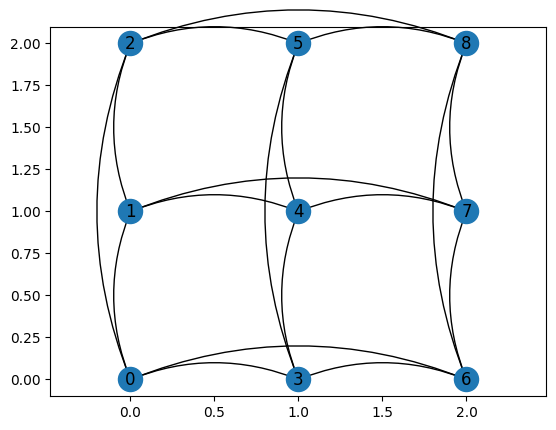

In [ ]:
graph = nk.graph.Square(3, pbc = True)
graph.draw()

hi = nk.hilbert.Spin(s = 1/2, N = graph.n_nodes)

Aqui, utilizaremos uma função bastante interessante do NetKet e vamos trocar o nosso modelo RBM usado anteriormente por uma RBM Simétrica, utilizando a função `RBMSymm` e passando para ela, além dos parâmetros passados anteriormente, o grupo de translação do grafo que representa a geometria do sistema para que o modelo possa simplificar o número de parâmetros a otimizar com base nas simetrias do sistema.

In [ ]:
H = nk.operator.Ising(hilbert = hi, h = 1, J = 1, graph = graph)
model = nk.models.RBMSymm(alpha = 1, param_dtype = complex, symmetries = graph.translation_group())
op = nk.optimizer.RmsProp(learning_rate = 0.05)
sampler = nk.sampler.MetropolisLocal(hi)
vstate = nk.vqs.MCState(sampler = sampler, model = model)
print("Esse estado variacional tem", vstate.n_parameters, "parâmetros.")

precon = nk.optimizer.SR(qgt = nk.optimizer.qgt.QGTOnTheFly(holomorphic = True))

driver = nk.driver.VMC(H, optimizer = op, variational_state = vstate, preconditioner = precon, diag_shift = 1e-2)
driver.run(n_iter = 50, out = 'out')

Esse estado variacional tem 11 parâmetros.


100%|██████████| 50/50 [00:04<00:00, 11.27it/s, Energy=-11.960-0.001j ± 0.019 [σ²=0.367, R̂=1.0072]]


(JsonLog('out', mode=write, autoflush_cost=0.005)
   Runtime cost:
   	Log:    0.019316911697387695
   	Params: 0.001485586166381836,)

Notem como o número de parâmetros diminuiu de 99 para 11 em comparação com a cadeia unidimensional do exemplo anterior! Em tese, como ambos esses sistemas tem 9 partículas, eles teriam o mesmo número de parâmetros para otimizar. Porém, considerar as simetrias do reticulado quadrado diminui em muito os parâmetros necessários para a otimização.

In [ ]:
print("Energia obtida com o ansatz RBM:", vstate.expect(H))
Hamil = H.to_dense()
print("Energia obtida com diagonalização exata:",min(sp.linalg.eigvals(Hamil)))

Energia obtida com o ansatz RBM: -11.955+0.057j ± 0.020 [σ²=0.408, R̂=1.0111]
Energia obtida com diagonalização exata: (-12.01989487885152+0j)


Até agora otimizamos estados variacionais e computamos energias dos ground states para dois sistemas. Entretanto, não investigamos nenhuma dinâmica ou interação interessante no modelo de Ising. Isso se dá pelo fato de que só analisamos o ground state do modelo de Ising para $J = h = 1$. Variando os valores de $h$ ou de $J$, podemos identificar mudanças no comportamento do sistema e até transições de fase! Para isso, vamos também definir alguns observáveis para analisar junto à energia do ground state do sistema, nominalmente, a magnetização total (soma dos spins na direção) dos eixos $x$ e $z$ e computá-los junto à energia para múltiplos valores de $J$.

In [ ]:
from netket.operator.spin import sigmax, sigmaz #importando os operadores de spin nas direções x e z, que já vem prontos no NetKet.

In [ ]:
jvec = np.linspace(-5, 5, 30) # lista de 30 valores para J, igualmente espaçados entre -5 e 5.
magx = sum([sigmax(hi, i) for i in range(graph.n_nodes)]) # Magnetização no eixo x.
magz = sum([sigmaz(hi, i) for i in range(graph.n_nodes)]) #Magnetização no eixo z.
Evec = []
Mxvec = []
Mzvec = []

# O loop abaixo otimiza um estado variacional como feito anteriormente para cada valor do termo de interação em jvec e salva os valores da energia e das magnetizações nos vetores Evec, Mxvec e Mzvec.

for j in jvec:
    H = nk.operator.Ising(hilbert = hi, h = 1, J = j, graph = graph)
    model = nk.models.RBMSymm(alpha = 1, param_dtype = complex, symmetries = graph.translation_group(), use_hidden_bias = True)
    op = nk.optimizer.RmsProp(learning_rate = 0.01)

    sampler = nk.sampler.MetropolisLocal(hi)
    vstate = nk.vqs.MCState(sampler = sampler, model = model)

    precon = nk.optimizer.SR(qgt = nk.optimizer.qgt.QGTOnTheFly(holomorphic = True, diag_shift = 1e-2))

    driver = nk.driver.VMC(H, optimizer = op, variational_state = vstate, preconditioner = precon)

    driver.run(n_iter = 50, out = 'out')
    Evec.append(vstate.expect(H).mean.real)
    Mxvec.append(vstate.expect(magx).mean.real)
    Mzvec.append(vstate.expect(magz).mean.real)

Agora que temos nossos primeiros resultados, podemos plotar eles utilizando o módulo `matplotlib.pyplot`, que importamos no começo do notebook como `plt`. Devido ao fato de que alguns dos cálculos a partir desse momento podem demorar um pouco para rodar dependendo do hardware utilizado, deixaremos os plots dos resultados abaixo de cada código.

In [ ]:
plt.scatter(jvec, Evec)
plt.xlabel("J")
plt.ylabel("Energia do ground state")

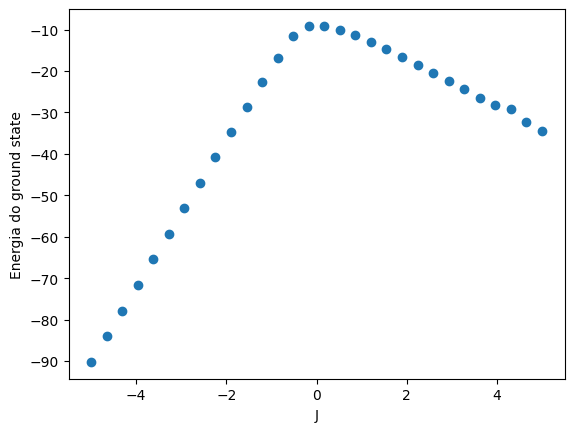

In [ ]:
plt.scatter(jvec, Mxvec)
plt.xlabel("J")
plt.ylabel("Magnetização ao longo do eixo x")

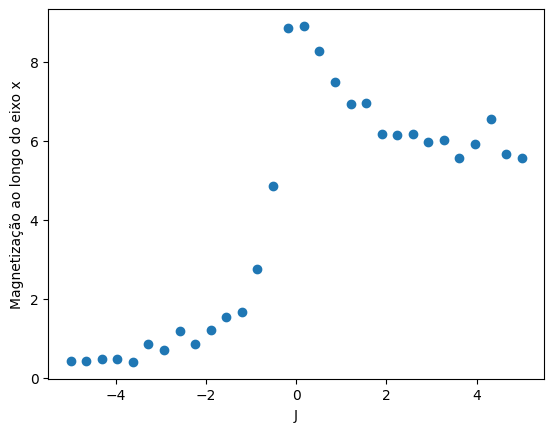

In [ ]:
plt.scatter(jvec, Mzvec)
plt.xlabel("J")
plt.ylabel("Magnetização ao longo do eixo z")

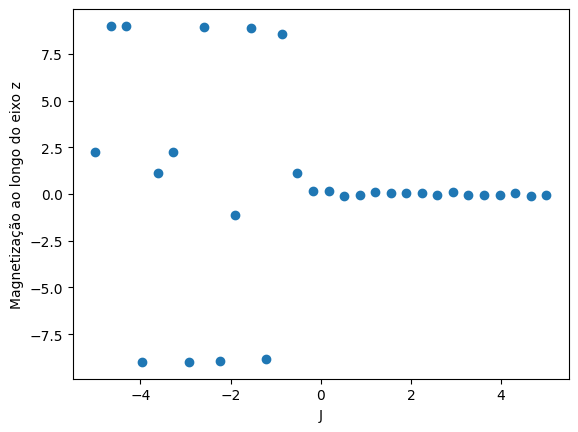

O primeiro gráfico, que mostra a energia do ground state, mostra claramente que a energia cresce conforme o termo de interação $J$ sai do negativo e se aproxima do $0$, voltando a decrescer posteriormente, embora com menos rapidez.

Os dois outros gráficos, relativos à magnetização total nos eixos $x$ e $z$, apresentam comportamentos mais interessantes. O gráfico da magnetização no eixo $x$ começa próximo ao $0$ e sobe rapidamente até o seu máximo no valor $9$ quando $J = 0$. Isso pode ser explicado pelo fato de que $J$ é um termo de interação relacionado aos spins no eixo $z$ enquanto $h$ é uma intensidade de campo no eixo $x$. Quando $|J| >> h = 1$ para $J < 0$, a alta intensidade das interações entre spins vizinhos governa quase que totalmente o comportamento do sistema. Conforme variamos a intensidade dessas interações, vemos que quando elas se aproximam do valor de $h$ a magnetização no eixo $x$ se torna relevante, efetivamente dominando o comportamento do sistema quando $J \approx 0$. Vemos também, porém, que para $J > 0$ a magnetização no eixo $x$ não volta a se tornar irrelevante como ocorria anteriormente. Um possível motivo para isso será discutido após a análise da magnetização ao longo do eixo $z$.

O terceiro gráfico, que ilustra a variação da magnetização no eixo $z$ em função do valor do termo de interação $J$, tem um comportamento ainda mais interessante que o anterior. Ele tem uma transição bem clara entre valores de magnetização simétricos próximos a $8$ e um regime em que a magnetização é efetivamente $0$. O que observamos aqui é justamente uma transição de fase entre um regime ferromagnético, em que os spins do ground state tendem a se alinhar na mesma direção, independente de ser para cima ou para baixo, gerando uma forte magnetização positiva ou negativa, que ocorre quando $J < 0$ e um regime antiferromagnético, em que os spins vizinhos tendem a ter direções opostas no ground state, de forma que a magnetização total no eixo $z$ tende a 0 quando $J > 0$. Esse fenômeno explica o fato de que a magnetização no eixo x se mantém mais relevante quando $J >0$, uma vez que o sistema se encontra numa fase diferente e pode exibir propriedades diferentes.

É importante salientar que, no geral, na literatura sobre as transições de fase do modelo de Ising com campo transversal, determina-se uma fase ferromagnética para $J >0$ e uma fase antiferromagnética para $J < 0$, o contrário do que observamos aqui. Isso se dá pelo fato de que, enquanto nós consideramos sinais de $-$ nas constantes de interação quando explicamos o Hamiltoniano do modelo, tal como é feito tipicamente em livros e artigos científicos, o NetKet não considera esse sinal, efetivamente invertendo o comportamento do sistema com relação aos valores de $J$. Essa inversão, porém, é meramente um artefato matemático e não afeta em nada a interpretação dos resultados.

## **Diagramas de fase**

Na última seção, pudemos observar um fenômeno bastante interessante ao variarmos o termo de interação $J$ do nosso modelo de Ising. Agora, para finalizar o estudo desse sistema, vamos variar não só o valor de $J$, como também o valor de $h$ para gerar uma das ferramentas gráficas mais importantes do estudo de física da matérica condensada e imprenscindível no estudo das transições de fase de qualquer sistema quântico ou termodinâmico: os diagramas de fase. Diagramas de fase são gráficos que buscam representar uma ou mais quantidades físicas em termos de outras de forma a tornar visível o comportamento do sistema para várias condições diferentes e evidenciar transições de fase como as observadas acima.

Para gerar diagramas de fase do modelo de Ising, podemos variar os termos $J$ e $h$ e guardar os resultados da energia do estado fundamental e das magnetizações nos eixos $x$ e $z$ em matrizes que usaremos depois para plotar figuras "colormesh" com a biblioteca `matplotlib`. Esse tipo de figura é bastante útil para visualizar transições de fase, como veremos abaixo.

É importante salientar que, na célula abaixo, estaremos gerando matrizes 30 x 30 e otimizando um estado para cada uma das entradas de uma matriz dessas. Dessa forma, estaremos otimizando 900 estados, o que pode demorar uma hora ou mais, dependendo do hardware utilizado. Por isso, os gráficos resultantes estarão já em display abaixo dos códigos respectivos. De qualquer forma, não deixem isso desencorajar vocês de modificar o código e investigar melhor os fenômenos que podem acontecer entre fases de sistemas de muitos corpos!

In [ ]:
magx = sum([sigmax(hi, i) for i in range(graph.n_nodes)]) # Definindo a magnetização total no eixo x.
magz = sum([sigmaz(hi, i) for i in range(graph.n_nodes)]) # Definindo a magnetização total no eixo z.
hvec = np.linspace(0, 5, 30) # Criando lista com 30 valores igualmente espaçados de h variando de 0 a 5. Não analisaremos h negativo pois é variar o seu módulo que gera comportamentos interessantes.
jvec = np.linspace(-5, 5, 30) # Criando lista com 30 valores igualmente espaçados de J variando de -5 a 5.
E = np.zeros([len(hvec), len(jvec)]) # Matriz para os valores de E.
Mx = np.zeros([len(hvec), len(jvec)]) # Matriz para os valores da magnetização no eixo x.
Mz = np.zeros([len(hvec), len(jvec)]) # Matriz para os valores da magnetização no eixo z.

for i in range(30):
  for j in range(30):
    H = nk.operator.Ising(hilbert = hi, h = hvec[i], J = jvec[j], graph = graph)
    model = nk.models.RBMSymm(alpha = 1, param_dtype = complex, symmetries = graph.translation_group(), use_hidden_bias = True)
    op = nk.optimizer.RmsProp(learning_rate = 0.01)

    sampler = nk.sampler.MetropolisLocal(hi)
    vstate = nk.vqs.MCState(sampler = sampler, model = model)

    precon = nk.optimizer.SR(qgt = nk.optimizer.qgt.QGTOnTheFly(holomorphic = True, diag_shift = 1e-2))

    driver = nk.driver.VMC(H, optimizer = op, variational_state = vstate, preconditioner = precon)

    driver.run(n_iter = 50, out = 'out')

    E[i, j] = (vstate.expect(H).mean.real)
    Mx[i, j] = (vstate.expect(magx).mean.real)
    Mz[i, j] = (vstate.expect(magz).mean.real)

In [ ]:
plt.pcolormesh(jvec, hvec, E, cmap = 'jet')
plt.title("Energia do ground state")
plt.xlabel("J")
plt.ylabel("h")
plt.colorbar()

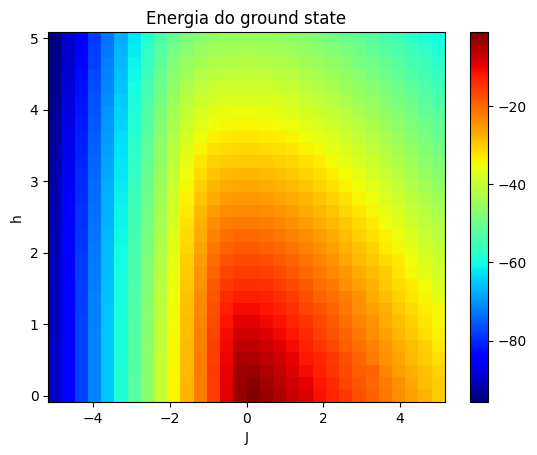

In [ ]:
plt.pcolormesh(jvec, hvec, Mx, cmap = 'turbo')
plt.title("Magnetização no eixo x")
plt.xlabel("J")
plt.ylabel("h")
plt.colorbar()

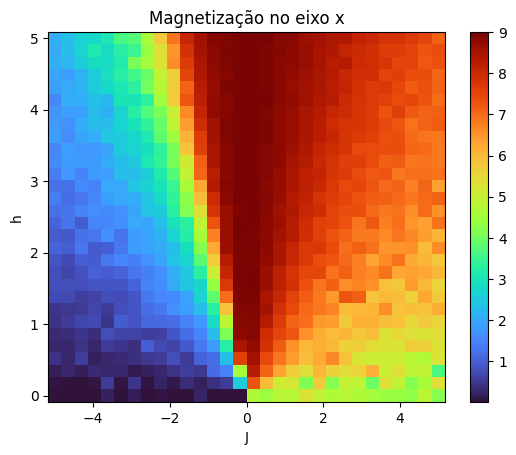

In [ ]:
plt.pcolormesh(jvec, hvec, Mz, cmap = 'turbo')
plt.title("Magnetização no eixo z")
plt.xlabel("J")
plt.ylabel("h")
plt.colorbar()

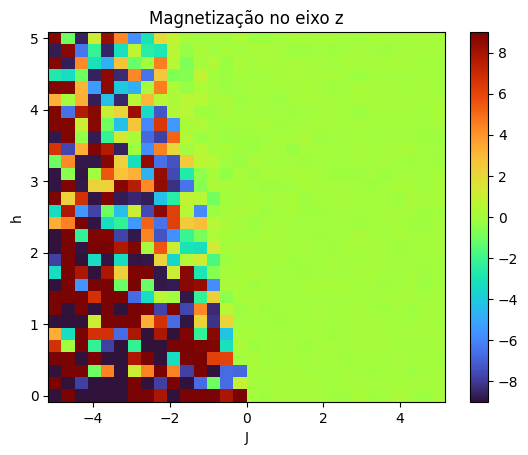

Os três plots colormesh acima enriquecem ainda mais nossa análise do modelo de Ising. O gráfico da energia do ground state nos mostra estados com energia muito baixa para $J \approx -5$ e valores bem diversos de energia conforme aumentamos $h$, tendo um pico na energia do ground state próximo ao $J = 0$.

O gráfico da magnetização no eixo $x$ uma faixa de magnetização baixa para valores negativos de $J$, faixa essa que se torna mais extensa conforme $h$ chega mais próximo de $0$, exibindo, também, um regime de alta magnetização no eixo $x$ quando $J \approx 0$.

Por fim, o gráfico da magnetização no eixo $z$ exibe um comportamento basicamente dividido em duas fases: uma fase ferromagnética, onde no geral as magnetizações ficam próximas de $8$ ou $-8$ quando todos os spins se alinham, e uma fase antiferromagnética, em que os spins vizinhos se dispõem em direções opostas e a magnetização tende a $0$.

## **Conclusões**

Nesse notebook, introduzimos o conceito de um problema quântico de muitos corpos e discutimos as dificuldades de tratá-lo computacionalmente, exemplificando com o caso do modelo de Ising. Depois disso, introduzimos uma nova metodologia criada para tratar esse tipo de problema, o Neural-Network Quantum States e exemplificamos seu funcionamento através da biblioteca NetKet, que implementa o formalismo do NQS de forma simples e intuititva. Tendo introduzido o NetKet, utilizamos ele para achar ground states e analisar transições de fase de um modelo de Ising de campo transversal, identificando fases ferromagnéticas e antiferromagnéticas ao variar a intensidade do termo de interação $J$ e do campo magnético no eixo $x$, $h$, demonstrando o poder desse arcabouço para estudar sistemas quânticos de muitos corpos de forma intuitiva e simples.

## **Referências**


[1] Carleo, G., & Troyer, M. (2017). Solving the quantum many-body problem with artificial neural networks. Science, 355(6325), 602–606. https://www.jstor.org/stable/24918355.

[2] Filippo Vicentini, Damian Hofmann, Attila Szabó, Dian Wu, Christopher Roth,
Clemens Giuliani, Gabriel Pescia, Jannes
Nys, Vladimir Vargas-Calderón, Nikita Astrakhantsev, and Giuseppe Carleo. “NetKet
3: Machine Learning Toolbox for Many-Body Quantum Systems”. SciPost Phys.
CodebasesPage 7 (2022).

[3] Documentação do NetKet: https://netket.readthedocs.io/en/latest/.

